In [85]:
import networkx as nx
from rdkit import Chem

In [100]:
def mol_to_nx(mol):
    if mol is None:
        raise ValueError("mol is None (failed to read structure).")

    G = nx.Graph()
    conf = mol.GetConformer()

    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        pdbi = atom.GetPDBResidueInfo()

        pos = None
        if conf is not None:
            p = conf.GetAtomPosition(idx)
            pos = (float(p.x), float(p.y), float(p.z))

        G.add_node(
            idx,
            element=atom.GetSymbol(),
            Z=atom.GetAtomicNum(),
            atom_name=(pdbi.GetName().strip() if pdbi is not None else None),
            pos=pos,
        )
        
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        ai, aj = bond.GetBeginAtom(), bond.GetEndAtom()

        atom_syms   = (aj.GetSymbol(), ai.GetSymbol()) # this is weird here because I have undirected graph

        attr = {
        "atom_syms": atom_syms,
        }
        
        G.add_edge(i, j, **attr)

    return G


In [131]:
mol = Chem.MolFromPDBFile("../data/raw/1.pose.pdb", removeHs=True)
#mol2 = Chem.MolFromMol2File("../data/raw/sybyl.mol2")
G = mol_to_nx(mol)
#G2 = mol_to_nx(mol2)
print(list(G.nodes(data=True))[2:3])
print(list(G.edges(data=True))[4:5])
print(G.number_of_nodes(), G.number_of_edges())

[(2, {'element': 'C', 'Z': 6, 'atom_name': 'C2A', 'pos': (20.705, 22.883, 19.697)})]
[(2, 3, {'atom_syms': ('C', 'C')})]
43 46


In [126]:
from collections import defaultdict
def wl_refine(G, r=2, use_edge_labels=True, return_all_r=False):
    labels = {v: ('Z:', G.nodes[v]['Z']) for v in G.nodes()}  # radius-0 label: element only
    all_rounds = [labels]

    for _ in range(r):
        new_labels = {}
        for v in G.nodes():
            neigh_multiset = []
            for u in G.neighbors(v):
                if use_edge_labels and 'order' in G.edges[v, u]:
                    e = ('ord:', G.edges[v, u]['order'], 'arom:', G.edges[v, u].get('aromatic', False))
                    neigh_multiset.append((e, labels[u]))
                else:
                    neigh_multiset.append(labels[u])
            neigh_multiset.sort()
            new_labels[v] = ('self:', labels[v], 'N:', tuple(neigh_multiset))
        labels = new_labels
        all_rounds.append(labels)

    return all_rounds if return_all_r else labels


def wl_equivalence_classes(labels_dict):
    """Group nodes with identical labels into buckets."""
    buckets = defaultdict(list)
    for v, L in labels_dict.items():
        buckets[L].append(v)
    return list(buckets.values())

In [129]:
L_r = wl_refine(G, r=15, use_edge_labels=True)   # labels at radius 2
buckets = wl_equivalence_classes(L_r)           # symmetry/equivalence classes

In [128]:
buckets

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7, 8, 9],
 [10],
 [11],
 [12],
 [13],
 [14, 15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25, 26, 27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37, 38, 39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49, 50, 51],
 [52],
 [53],
 [54],
 [55],
 [56, 57],
 [58],
 [59],
 [60],
 [61, 72],
 [62, 71],
 [63, 64],
 [65, 66],
 [67, 77],
 [68],
 [69],
 [70],
 [73, 74],
 [75, 76]]

In [130]:
buckets

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7, 8, 9],
 [10],
 [11],
 [12],
 [13],
 [14, 15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25, 26, 27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37, 38, 39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49, 50, 51],
 [52],
 [53],
 [54],
 [55],
 [56, 57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63, 64],
 [65, 66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73, 74],
 [75, 76],
 [77]]

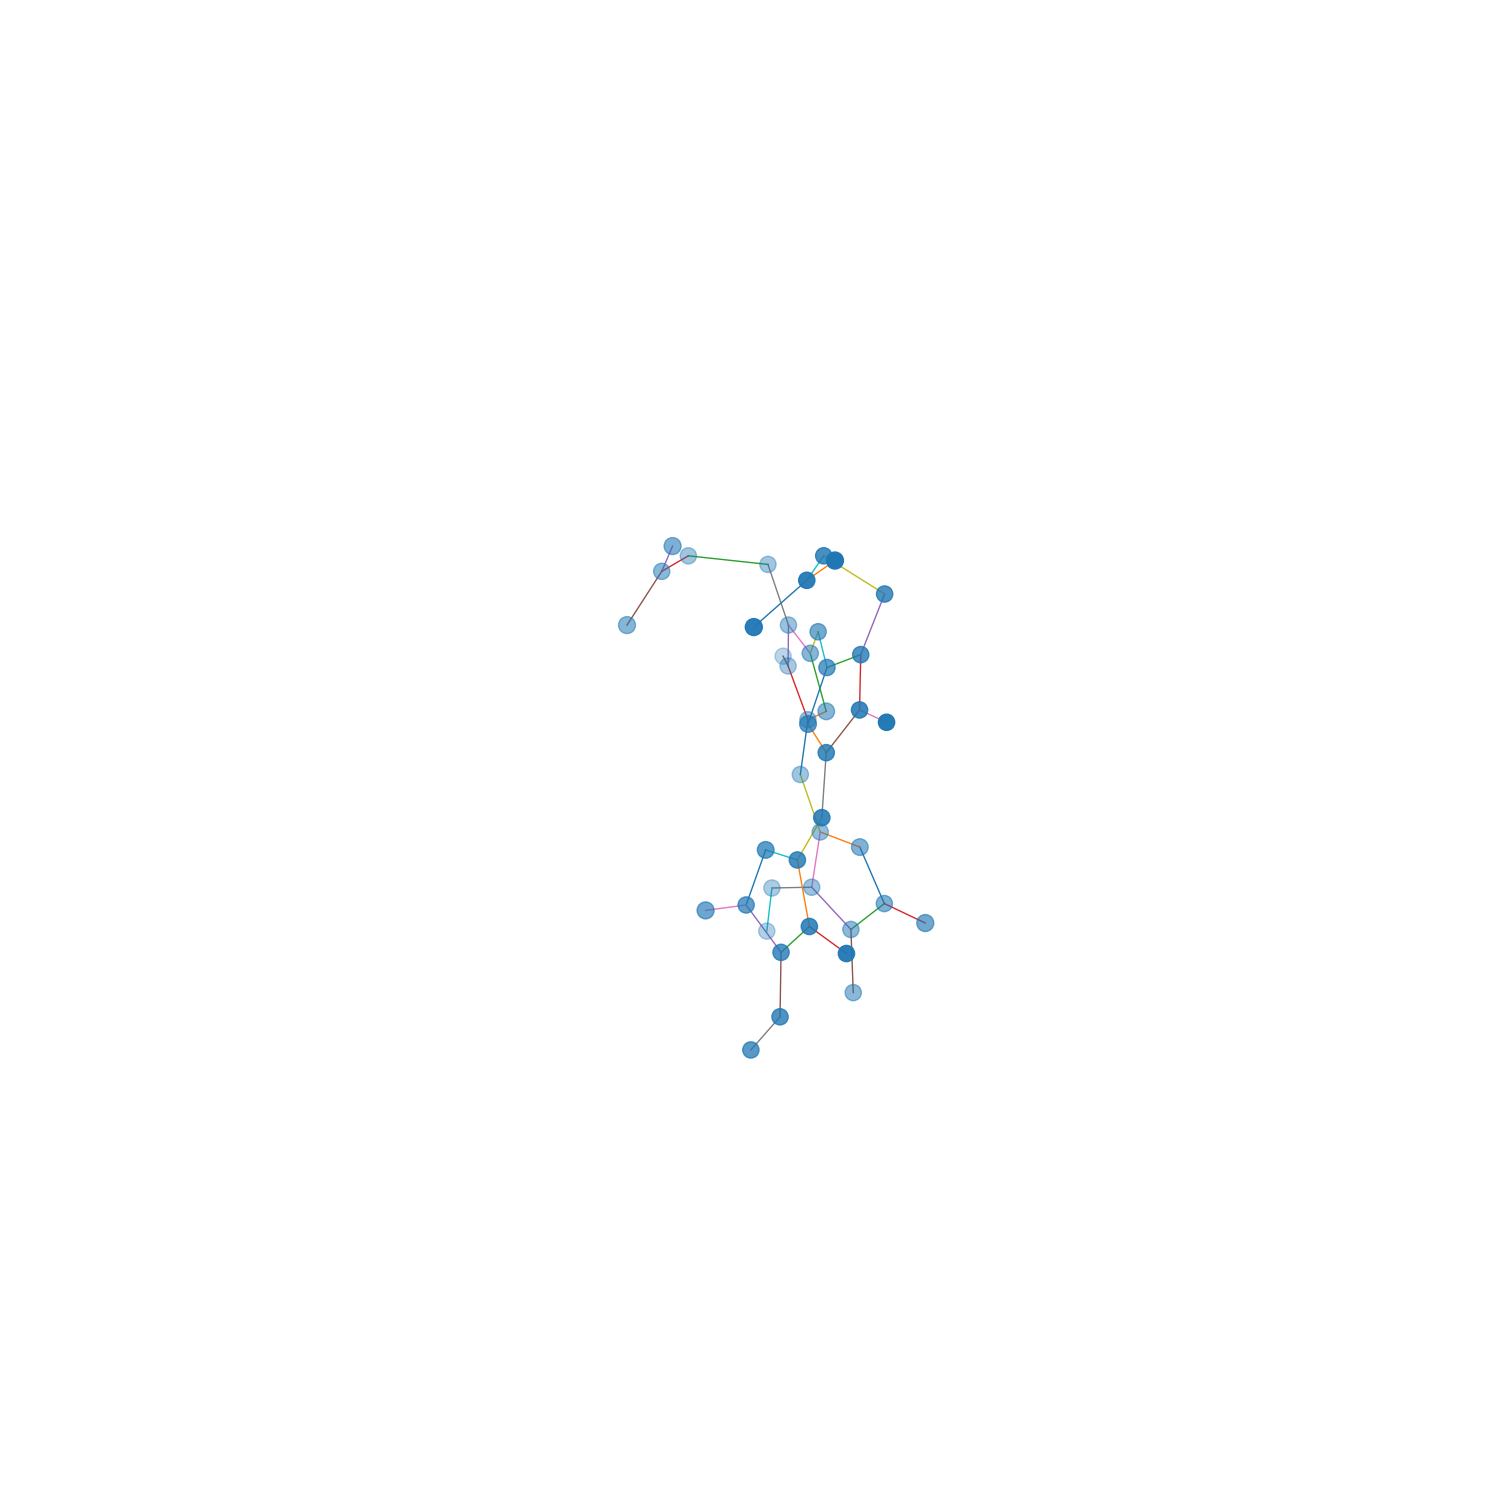

In [132]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
import numpy as np

def draw_mol_3d(G, node_size_scale=80):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.mouse_init(rotate_btn=1, zoom_btn=3)

    # get coords
    pos = {n: G.nodes[n].get("pos") for n in G.nodes()}
    # nodes without coords: skip
    pos = {n: p for n, p in pos.items() if p is not None}

    # draw edges as line segments
    for i, j in G.edges():
        if i in pos and j in pos:
            x = [pos[i][0], pos[j][0]]
            y = [pos[i][1], pos[j][1]]
            z = [pos[i][2], pos[j][2]]
            ax.plot(x, y, z, linewidth=1)

    # draw nodes
    xs = [pos[n][0] for n in pos]
    ys = [pos[n][1] for n in pos]
    zs = [pos[n][2] for n in pos]
    # simple sizing by element: heavier = bigger
    sizes = [node_size_scale * (G.nodes[n].get("Z", 6) ** 0.3) for n in pos]
    ax.scatter(xs, ys, zs, s=sizes)

    # equal aspect & light padding
    xyz = np.array([xs, ys, zs])
    mins = xyz.min(axis=1); maxs = xyz.max(axis=1)
    ranges = maxs - mins; max_range = ranges.max()
    centers = (maxs + mins) / 2
    ax.set_xlim(centers[0]-max_range/2, centers[0]+max_range/2)
    ax.set_ylim(centers[1]-max_range/2, centers[1]+max_range/2)
    ax.set_zlim(centers[2]-max_range/2, centers[2]+max_range/2)
    ax.set_axis_off()
    #ax.view_init(elev=-10, azim=50)
    plt.show()

draw_mol_3d(G)